In [ ]:
import keras.backend as k
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tensorflow as tf

In [ ]:
tf.compat.v1.disable_eager_execution()
img=keras.preprocessing.image.load_img("/content/ele.jpg")
x=keras.preprocessing.image.img_to_array(img)
x=x.reshape(1,x.shape[0],x.shape[1],x.shape[2])
batch_size=x.shape
shape=x.shape[1:]
x=keras.applications.vgg16.preprocess_input(x)

In [ ]:
vgg=keras.applications.vgg16.VGG16(include_top=False,input_shape=shape)

In [ ]:
new_model=keras.models.Sequential()
for layer in vgg.layers:
  if layer.name.endswith("pool"):
    new_model.add(keras.layers.AveragePooling2D())
  else:
    new_model.add(layer)

In [ ]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 598, 960, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 598, 960, 64)      36928     
                                                                 
 average_pooling2d_5 (Averag  (None, 299, 480, 64)     0         
 ePooling2D)                                                     
                                                                 
 block2_conv1 (Conv2D)       (None, 299, 480, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 299, 480, 128)     147584    
                                                                 
 average_pooling2d_6 (Averag  (None, 149, 240, 128)    0         
 ePooling2D)                                          

In [ ]:
def cut_off_model(count):
  model=keras.models.Sequential()
  output=None
  conv_layer_counter=0
  for layer in new_model.layers:
    if layer.name.endswith("conv1") or layer.name.endswith("conv2")  or layer.name.endswith("conv3"):
      conv_layer_counter+=1
    model.add(layer)    
    if conv_layer_counter==count:
      output=layer
      break
    
  return model,output

In [ ]:
c_model,output=cut_off_model(7)


target=k.variable(c_model.predict(x))
loss=k.mean(k.square(target-output.output))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:


grad=k.gradients(loss,new_model.input)

In [ ]:
loss_and_grad=k.function(inputs=[new_model.input],outputs=[loss]+grad)

In [ ]:
fake_input=np.random.randn(np.product(batch_size))

In [ ]:
def unprocess(img):
  img[...,0]=img[...,0]+103.939
  img[...,1]=img[...,1]+116.779
  img[...,2]=img[...,2]+126.68
  img=img[...,::-1]
  return img

In [ ]:
def scale(x):
  x=x-x.min()
  x=x/x.max()
  return x

In [ ]:
def wrapper(x_vec):
  l,g=loss_and_grad([x_vec.reshape(*batch_size)])
  return l.astype(np.float64),g.flatten().astype(np.float64)

In [ ]:
losses=[]
for _ in range(10):
  
  fake_input,l,_=scipy.optimize.fmin_l_bfgs_b(wrapper,fake_input,maxfun=50)#just an optimizer like adam
  fake_input=np.clip(fake_input,-127,127)
  
  print(l)
  losses.append(l)
  

1594.843017578125
818.4614868164062
564.3439331054688
433.85247802734375
354.9545593261719
301.88031005859375
262.4356689453125
231.67672729492188
209.2449951171875
191.6007080078125


In [ ]:
x1=fake_input.reshape(*batch_size)

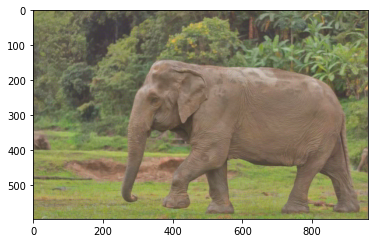

In [ ]:
x1=unprocess(x1)
g=scale(x1[0])

plt.imshow(g)

In [ ]:
def autocorrelation(x):
  x=k.batch_flatten(k.permute_dimensions(x,(2,0,1)))
  g=k.dot(x,k.transpose(x))/x.get_shape().num_elements()
  return g

In [ ]:
# vgg=keras.applications.vgg16.VGG16(include_top=False,input_shape=shape)
content_model=keras.Model(new_model.input,output.output)

In [ ]:
img=keras.preprocessing.image.load_img("/content/ele.jpg")
x=keras.preprocessing.image.img_to_array(img)
x=x.reshape(1,x.shape[0],x.shape[1],x.shape[2])
batch_size=x.shape
shape=x.shape[1:]
x=keras.applications.vgg16.preprocess_input(x)
target2=content_model.predict(x)

loss=k.mean(k.square(k.variable(target2)-content_model.output))



/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
img=keras.preprocessing.image.load_img("/content/style.jpg",target_size=(shape[0],shape[1]))
x=keras.preprocessing.image.img_to_array(img)
x=x.reshape(1,x.shape[0],x.shape[1],x.shape[2])
batch_size=x.shape
shape=x.shape[1:]
x=keras.applications.vgg16.preprocess_input(x)


In [ ]:
style_output=[layer.get_output_at(1) for layer in new_model.layers if layer.name.endswith("conv1")]

In [ ]:

len(style_output)

5

In [ ]:

style_model=keras.Model(new_model.input,style_output)

In [ ]:
target_style=[k.variable(y) for y in style_model.predict(x)  ]

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
weights=[1,2,3,4,5]

for i in range(len(target_style)):
  loss+=weights[i]*k.mean(k.square(autocorrelation(target_style[i][0])-autocorrelation(style_model.output[i][0])))

In [ ]:
grad=k.gradients(loss,new_model.input)

In [ ]:
loss_and_grad=k.function(inputs=[new_model.input],outputs=[loss]+grad)

In [ ]:
def wrapper(x_vec):

  l,g=loss_and_grad([x_vec.reshape(*batch_size)])
  
  return l.astype(np.float64),g.flatten().astype(np.float64)

In [ ]:
x=np.random.randn(np.product(batch_size))

In [ ]:
for _ in range(10):
  
  x,l,_=scipy.optimize.fmin_l_bfgs_b(wrapper,x,maxfun=10)#just an optimizer like adam
  x=np.clip(x,-127,127)
 
  print(l)
  losses.append(l)

240585.03125
143891.796875
94333.625
64894.97265625
50932.11328125
43144.08984375
37534.3671875
33819.29296875
31039.681640625
28959.974609375


In [ ]:
x1=x.reshape(*batch_size)

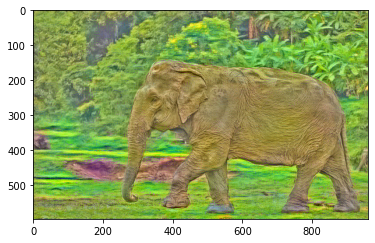

In [ ]:
x1=unprocess(x1)
g=scale(x1[0])
plt.imshow(g)

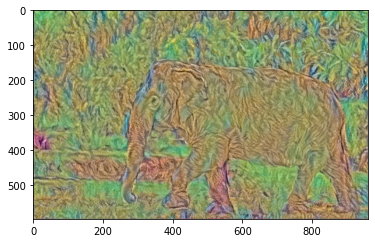

In [ ]:
jj=g*255
jj=jj.astype(np.uint8)
plt.imshow(jj)

In [ ]:
from PIL import Image
im = Image.fromarray(jj)
im.save("your_file.jpeg")